  0%|          | 0/10 [00:00<?, ?it/s]

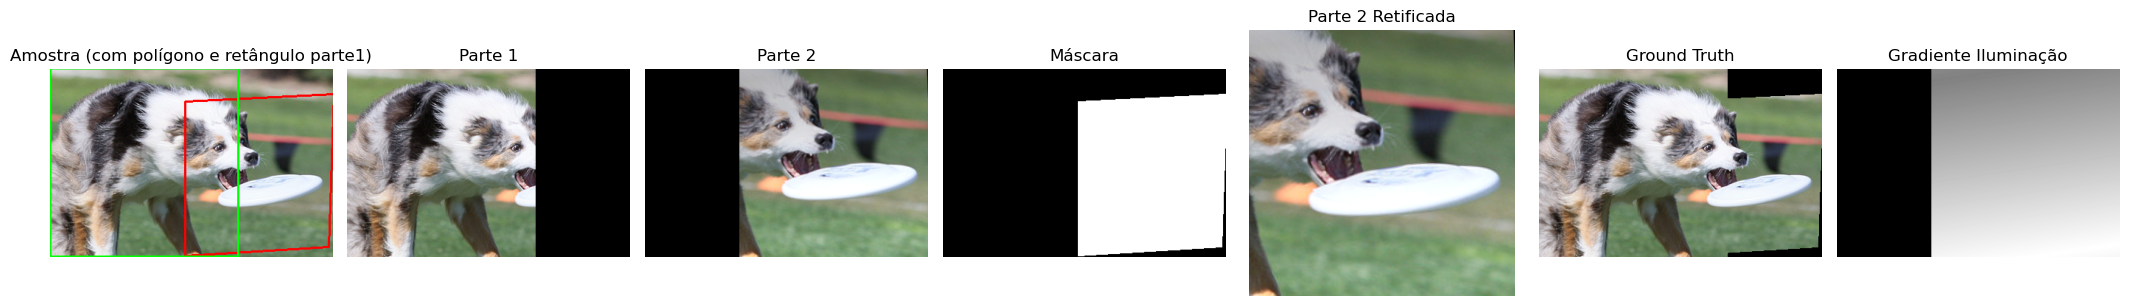

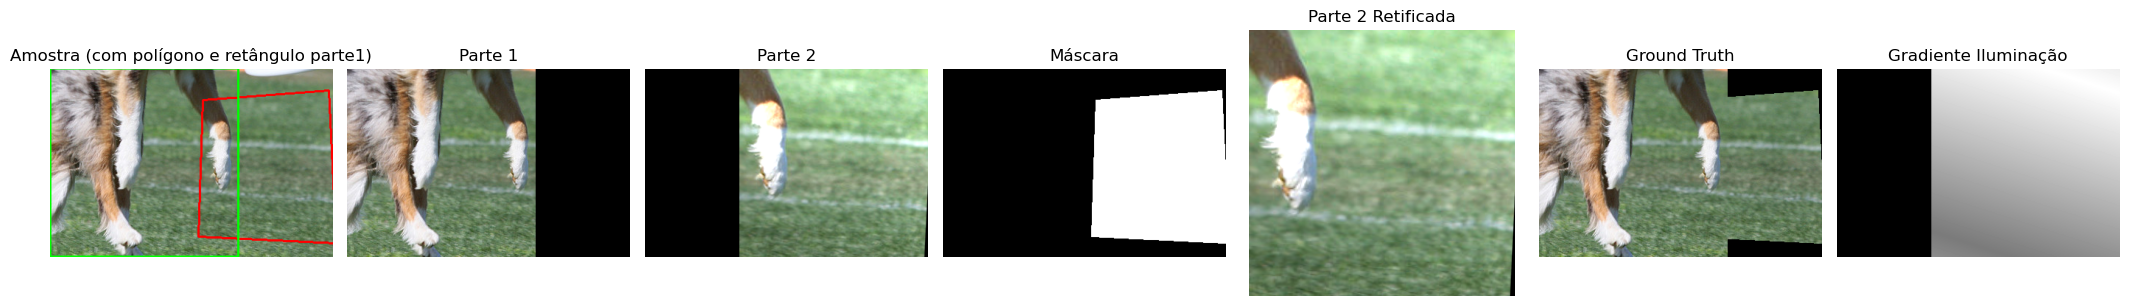

 10%|█         | 1/10 [00:00<00:05,  1.75it/s]

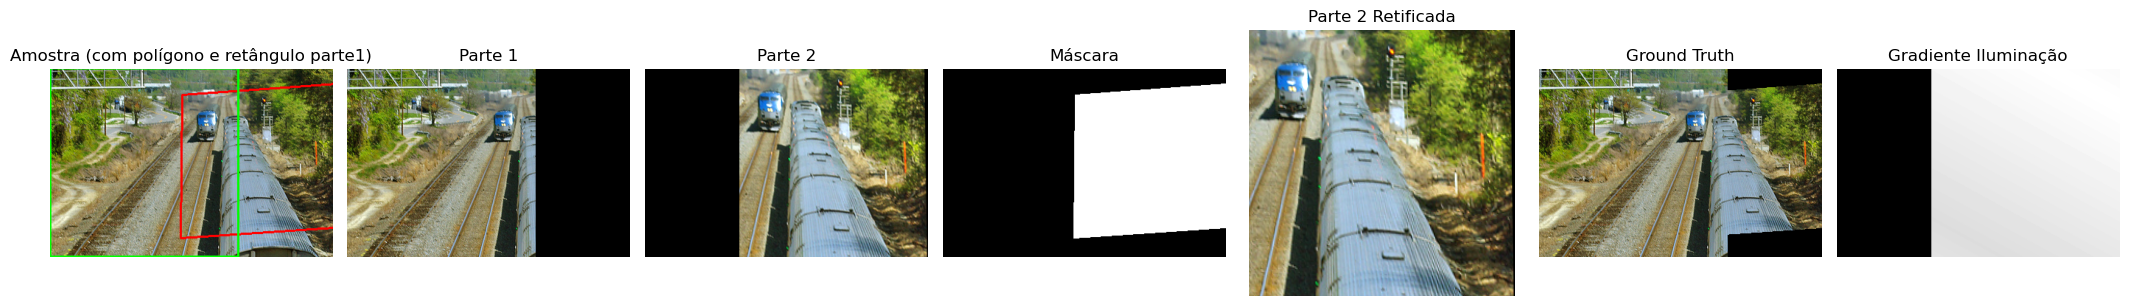

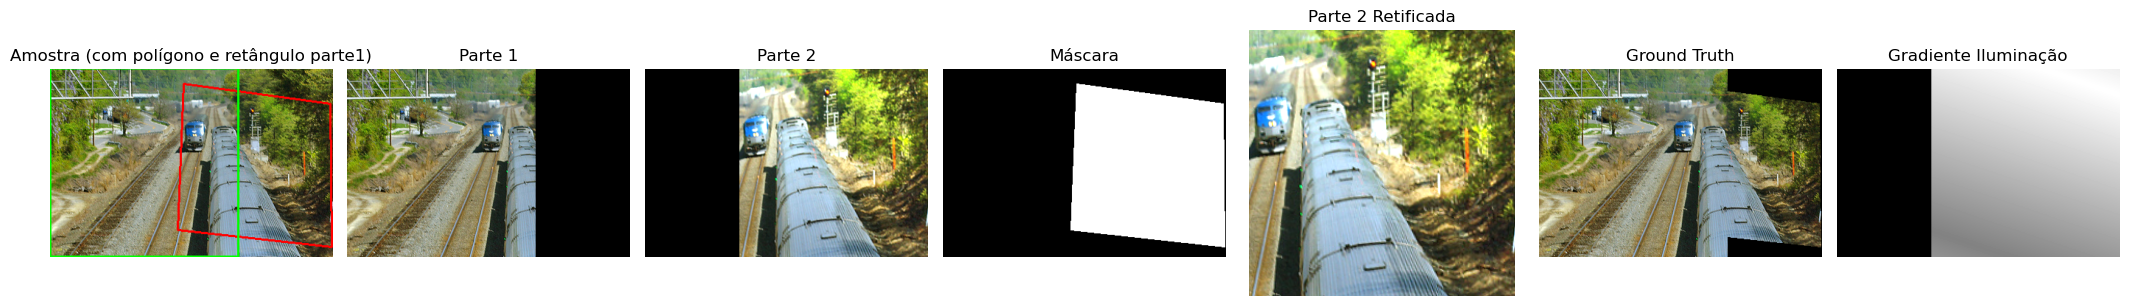

 20%|██        | 2/10 [00:01<00:04,  1.76it/s]

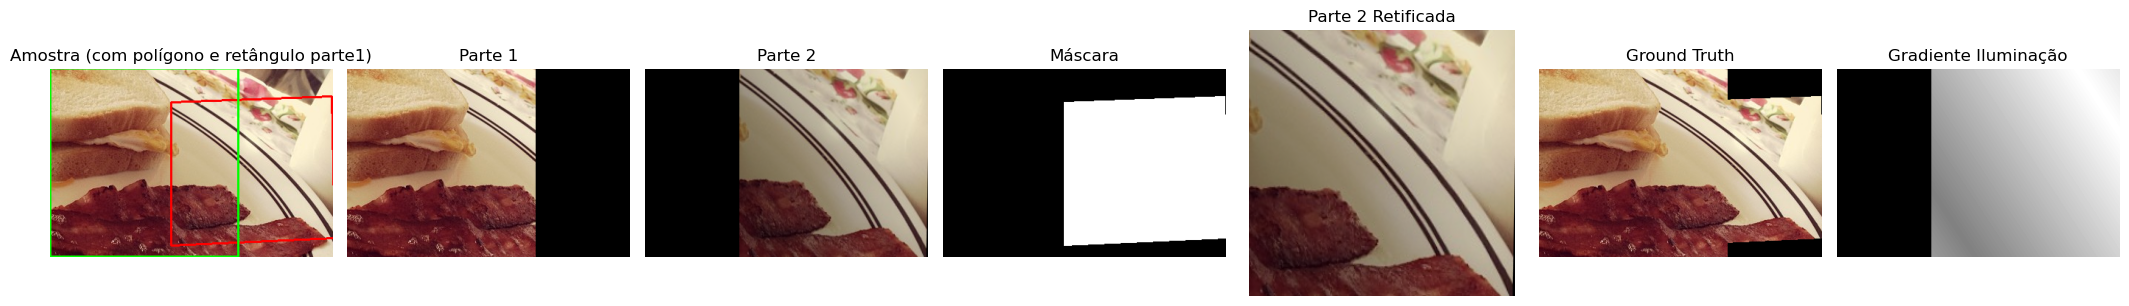

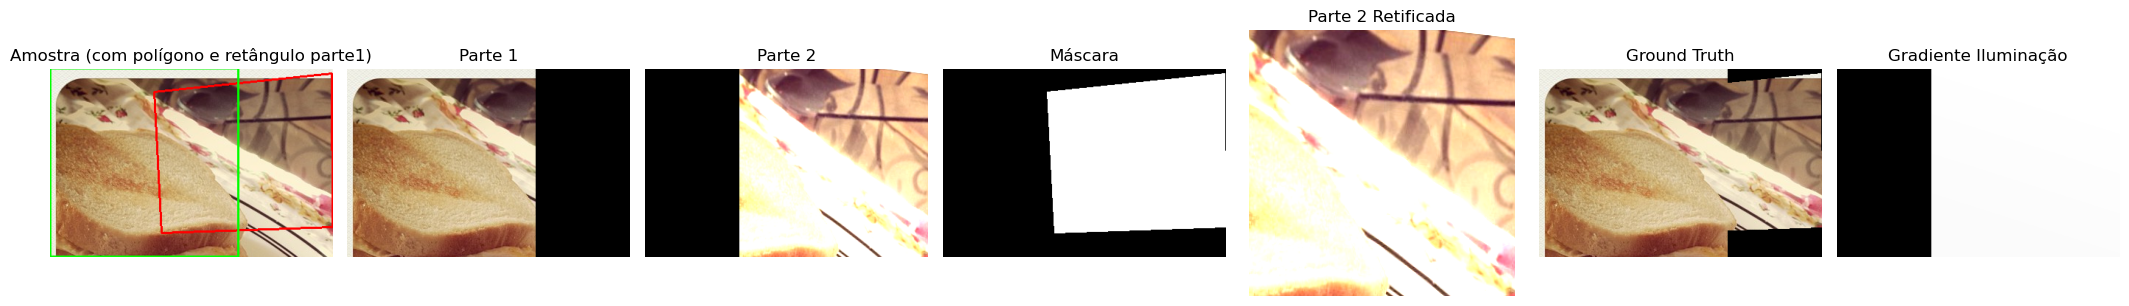

 30%|███       | 3/10 [00:01<00:03,  1.81it/s]

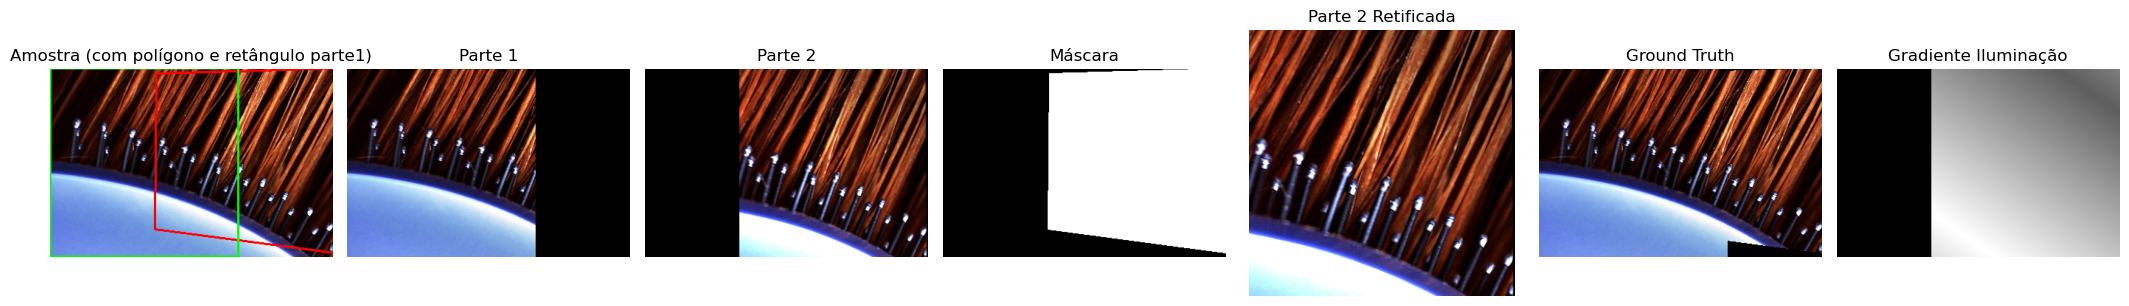

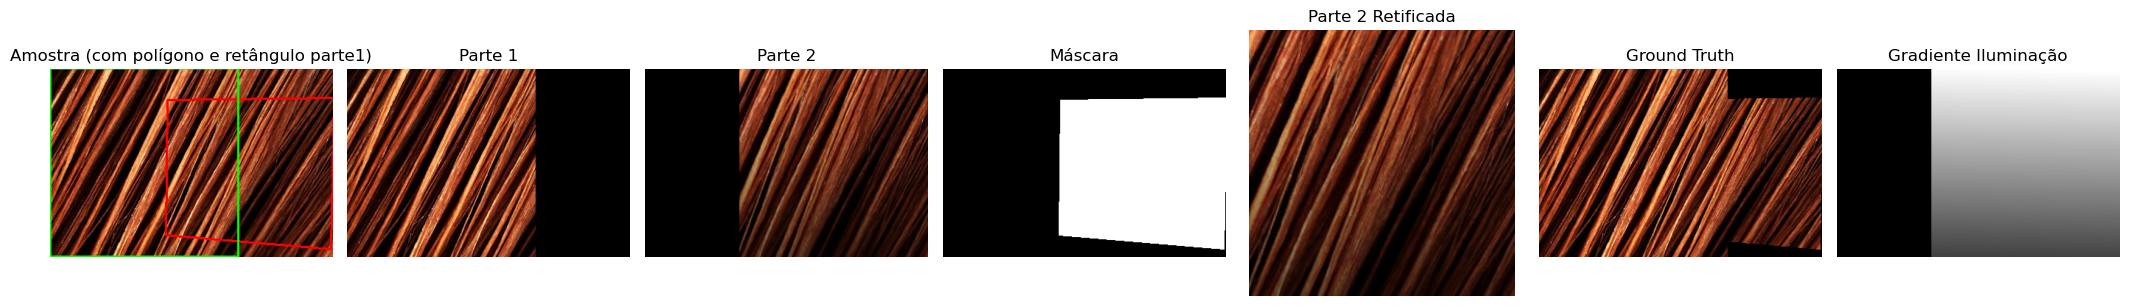

 40%|████      | 4/10 [00:02<00:03,  1.70it/s]

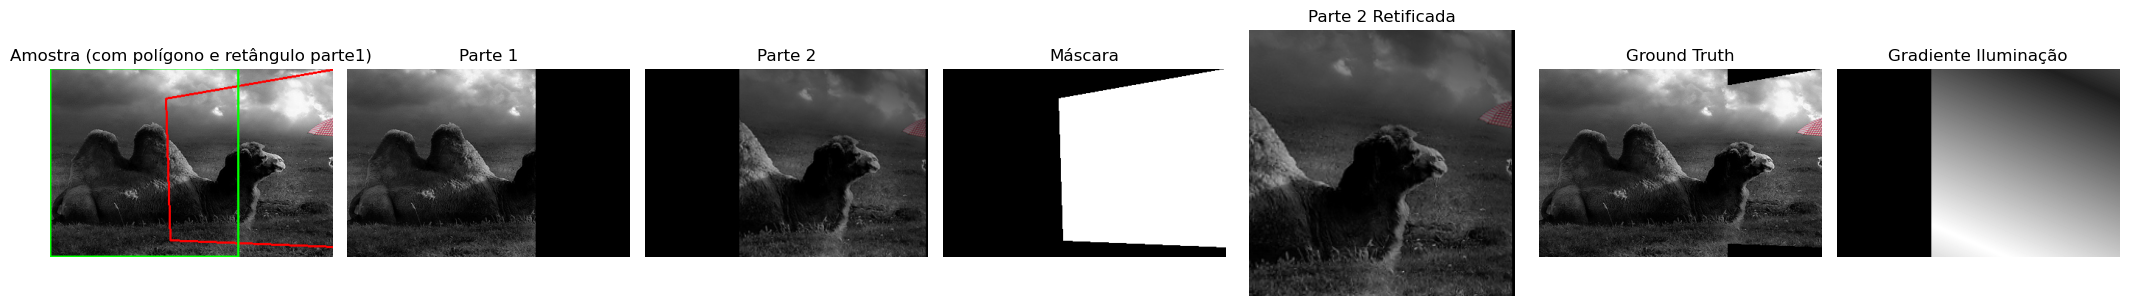

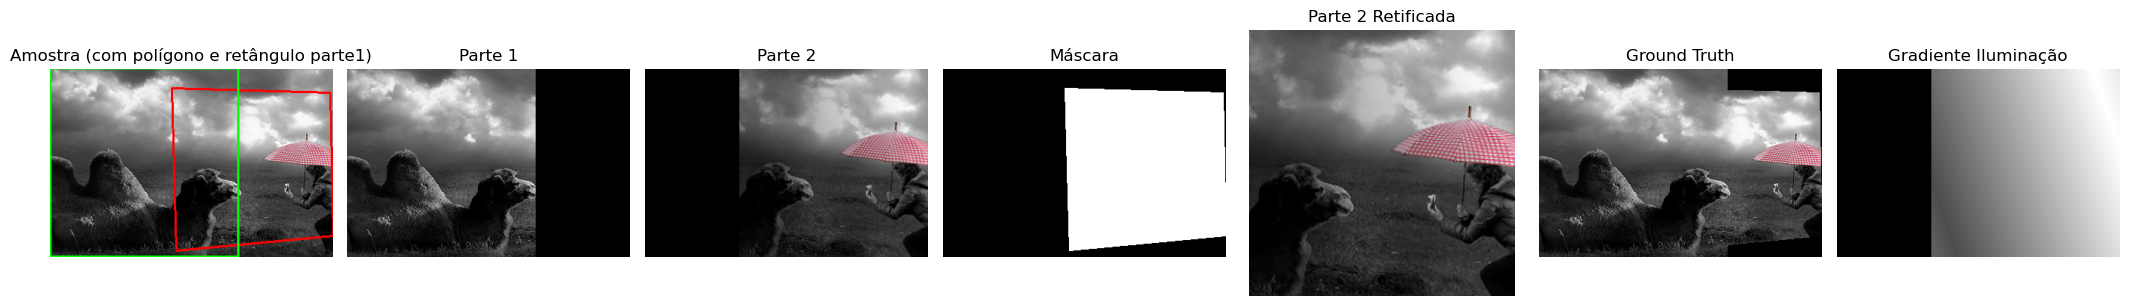

 50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

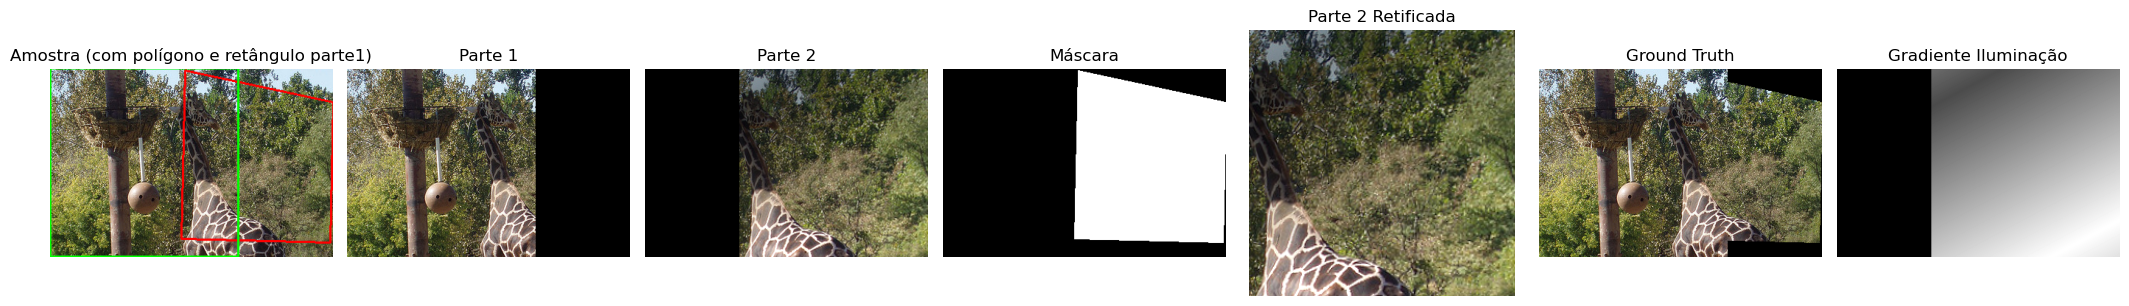

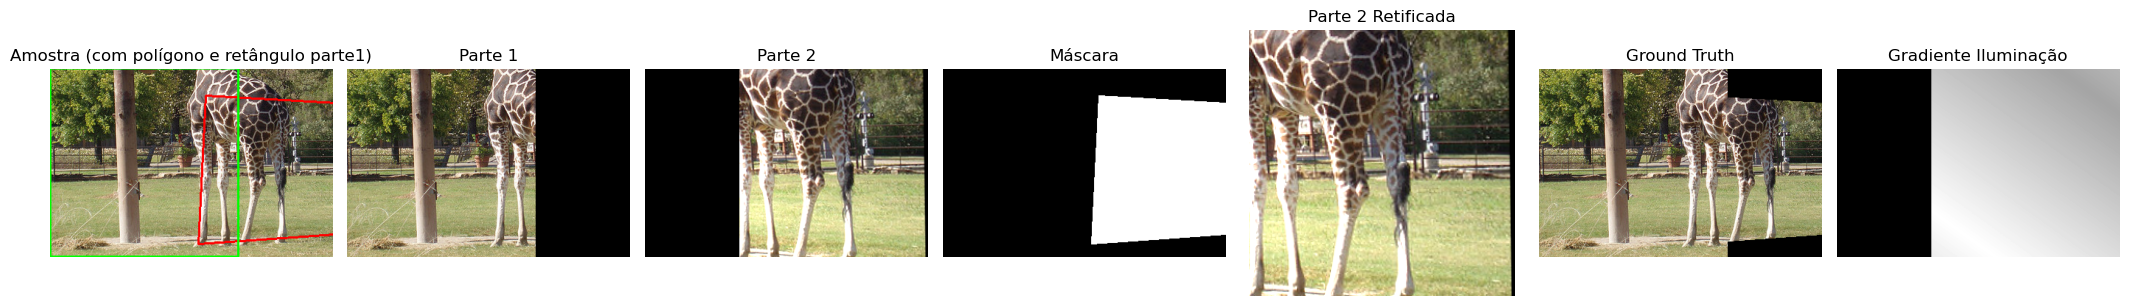

 60%|██████    | 6/10 [00:03<00:02,  1.78it/s]

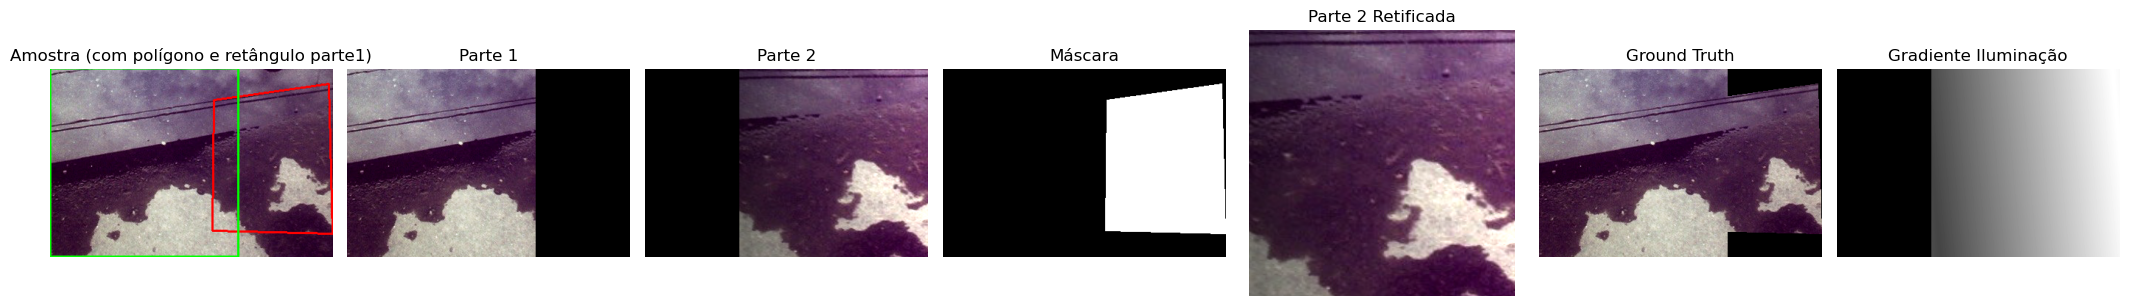

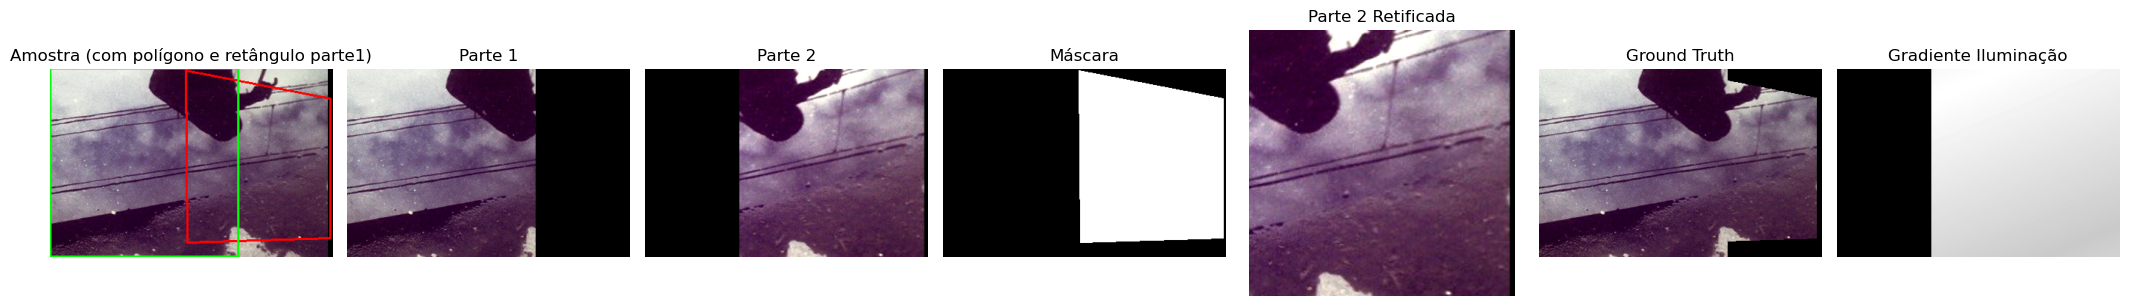

 70%|███████   | 7/10 [00:04<00:01,  1.74it/s]

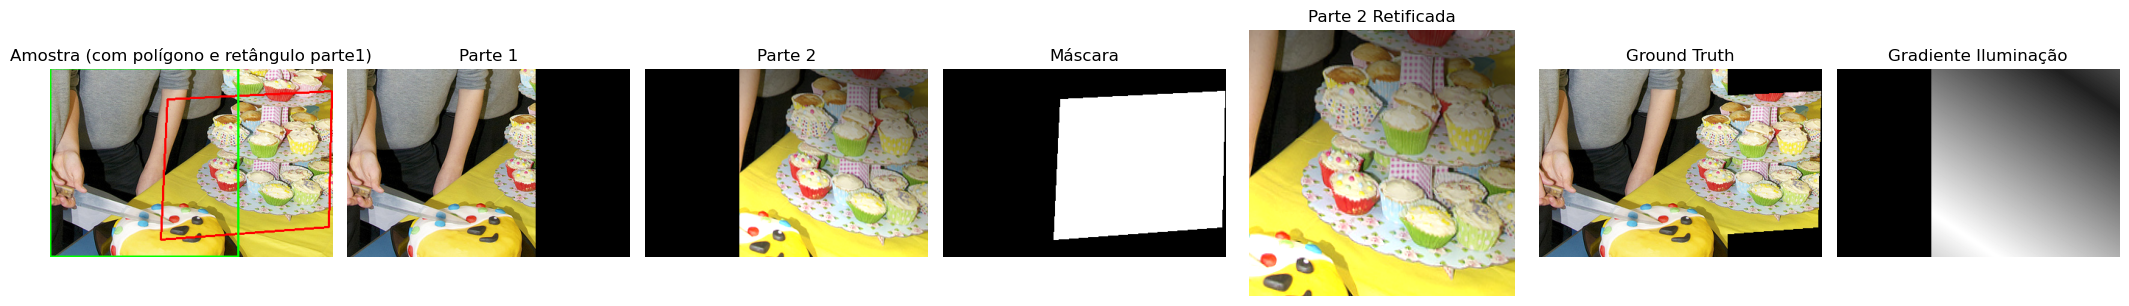

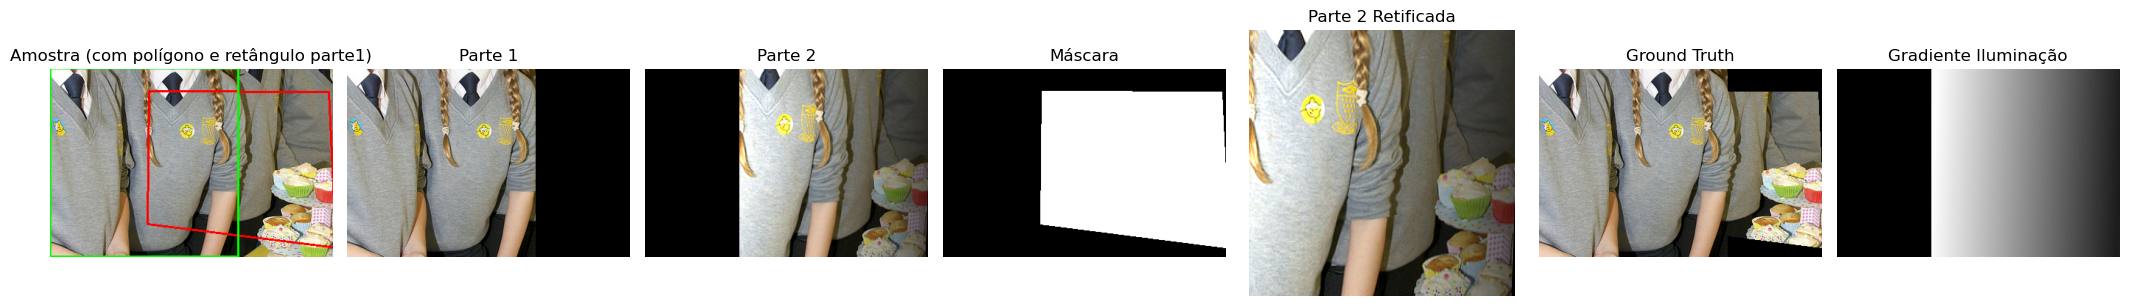

 80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

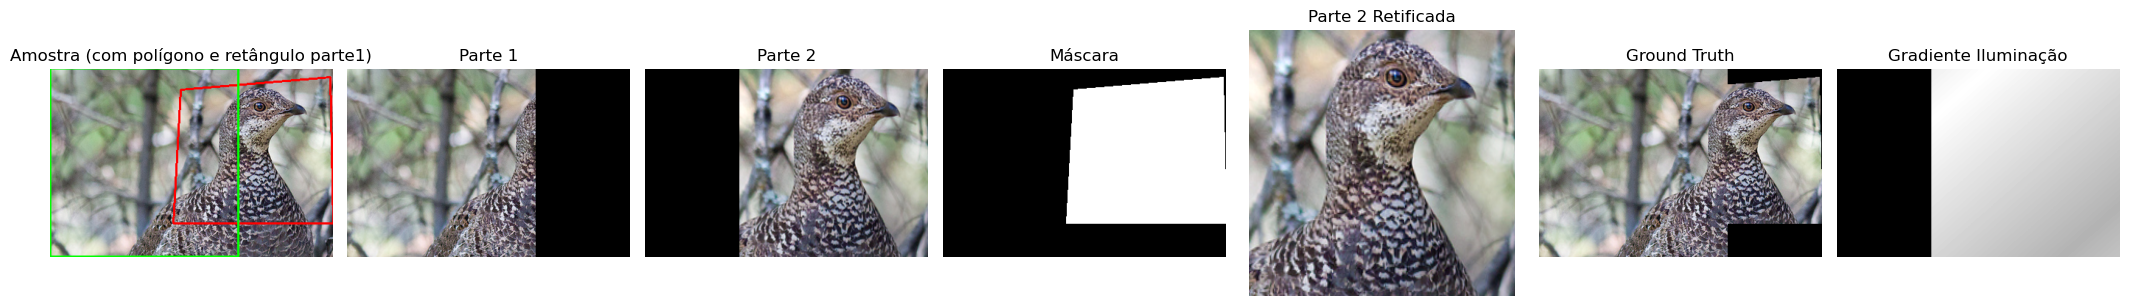

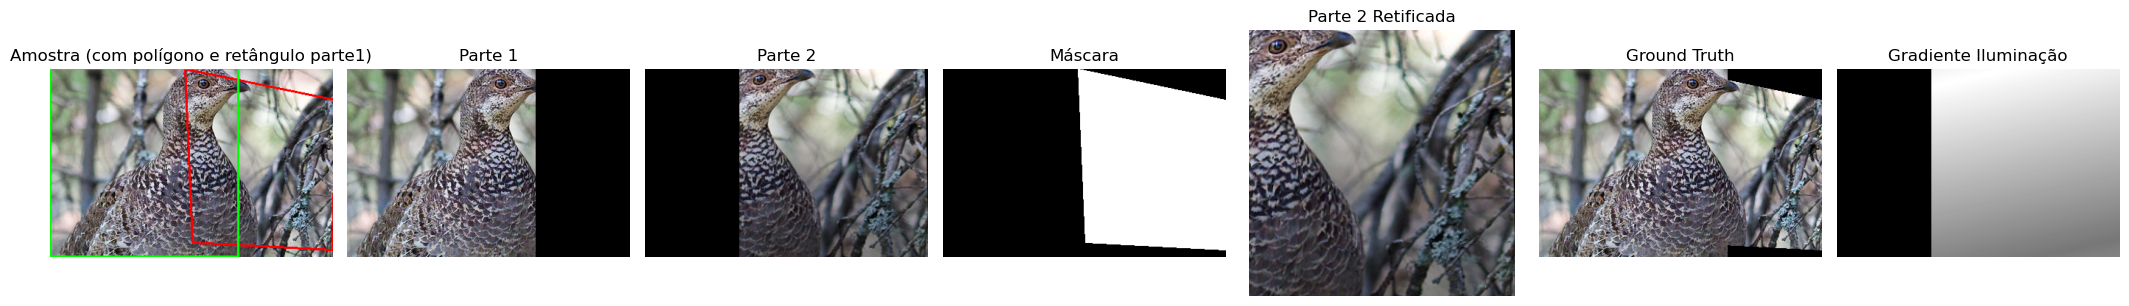

 90%|█████████ | 9/10 [00:05<00:00,  1.78it/s]

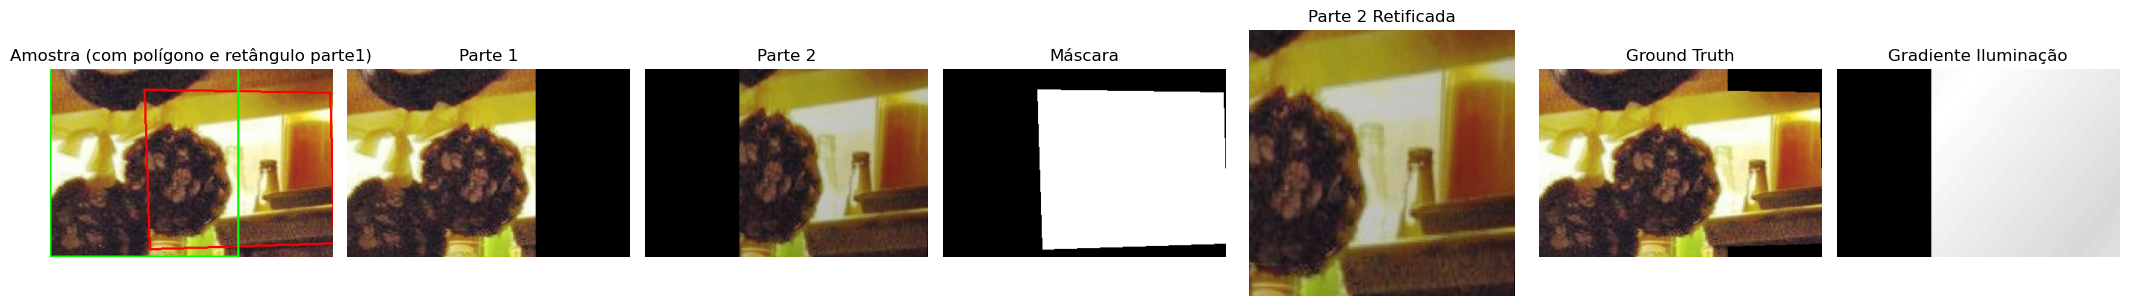

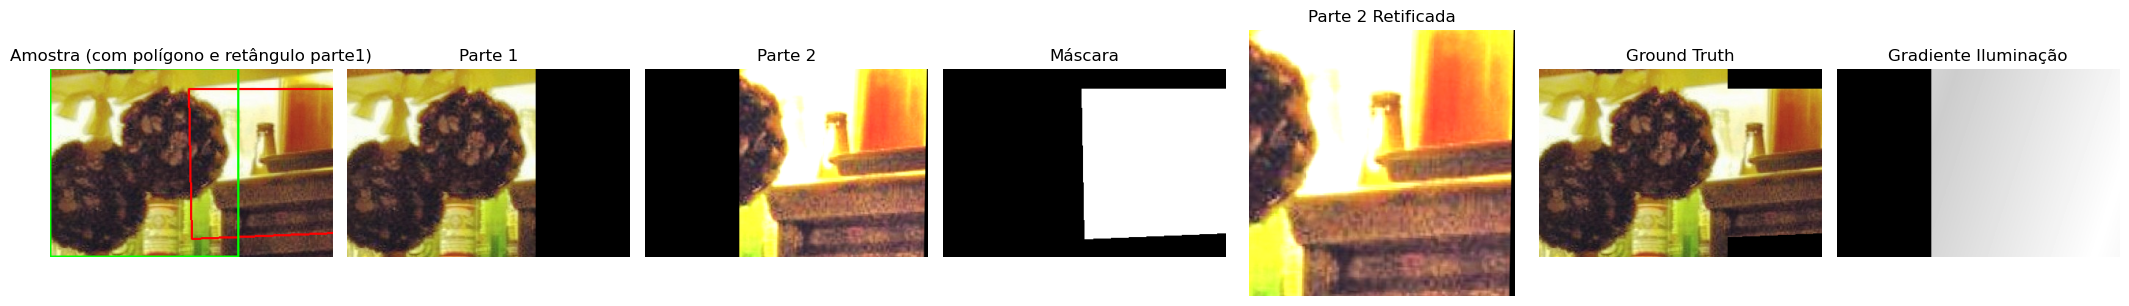

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


In [ ]:
import cv2
import numpy as np
import os
import random
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm import tqdm

# Diretórios
raw_dir = Path("./raw")
train_dir = Path("./train")
train_dir.mkdir(parents=True, exist_ok=True)

# Parâmetros gerais
amostras_por_imagem = 2     # Quantidade de amostras extraídas de um arquivo de imagem
altura = 256                # Dimensão da amostra
largura = 384               # Dimensão da amostra
parte_largura = 256         # largura de parte1, sobreposição será definida por parte2

# Parâmetros para o polígono (limites verticais para pontos topo e base)
limite_y_topo_min = 0
limite_y_topo_max = 50
limite_y_base_min = altura - 50
limite_y_base_max = altura - 1

# Parâmetros para variação de iluminação/brilho/contraste
variacao_min = 0.85  # proporção
variacao_max = 1.15  # proporção

debug = 1

def exibir_lado_a_lado(imagens, titulos, escala=3):
    n = len(imagens)
    plt.figure(figsize=(escala * n, escala))
    for i, (img, titulo) in enumerate(zip(imagens, titulos)):
        plt.subplot(1, n, i+1)
        if len(img.shape) == 2:  # imagem grayscale
            plt.imshow(img, cmap='gray')
        else:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
        plt.title(titulo)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def gerar_mascara_poligonal(img):
    h, w = img.shape[:2]
    min_x_esq = 128
    max_x_esq = 222
    x_esq_topo = random.randint(min_x_esq, max_x_esq)
    x_esq_base = x_esq_topo + random.randint(-10, 10)

    x_dir = w - 1
    x_dir_topo = x_dir + random.randint(-5, 5)
    x_dir_base = x_dir + random.randint(-5, 5)

    y_topo1 = random.randint(limite_y_topo_min, limite_y_topo_max)
    y_topo2 = random.randint(limite_y_topo_min, limite_y_topo_max)

    y_base1 = random.randint(limite_y_base_min, limite_y_base_max)
    y_base2 = random.randint(limite_y_base_min, limite_y_base_max)

    pt1 = [x_esq_topo, y_topo1]
    pt2 = [x_dir_topo, y_topo2]
    pt3 = [x_dir_base, y_base1]
    pt4 = [x_esq_base, y_base2]

    src_pts = np.array([pt1, pt2, pt3, pt4], dtype=np.float32)
    dst_pts = np.array([[0, 0], [256, 0], [256, 256], [0, 256]], dtype=np.float32)

    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [src_pts.astype(np.int32).reshape((-1, 1, 2))], 255)

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    retificada = cv2.warpPerspective(img, M, (256, 256))

    return retificada, mask, src_pts

def criar_groundtruth_final(amostra, mask, parte_largura=256):
    groundtruth = np.zeros_like(amostra)
    groundtruth[:, :parte_largura] = amostra[:, :parte_largura]

    mask_area_poligono = mask[:, parte_largura:]
    amostra_area_poligono = amostra[:, parte_largura:, :]

    mask_binaria = mask_area_poligono == 255
    mask_binaria_3canais = np.repeat(mask_binaria[:, :, np.newaxis], 3, axis=2)

    groundtruth_area = np.zeros_like(amostra_area_poligono)
    groundtruth_area[mask_binaria_3canais] = amostra_area_poligono[mask_binaria_3canais]
    groundtruth[:, parte_largura:] = groundtruth_area

    return groundtruth

def aplicar_padding(parte1, parte2):
    pad_dir = np.zeros((256, 384 - 256, 3), dtype=parte1.dtype)
    parte1_pad = np.concatenate((parte1, pad_dir), axis=1)

    pad_esq = np.zeros((256, 384 - 256, 3), dtype=parte2.dtype)
    parte2_pad = np.concatenate((pad_esq, parte2), axis=1)

    return parte1_pad, parte2_pad

def aplicar_variacao_iluminacao(parte):
    h, w = parte.shape[:2]

    # Criar gradiente horizontal
    inicio = random.uniform(variacao_min, variacao_max)
    fim = random.uniform(variacao_min, variacao_max)
    grad = np.tile(np.linspace(inicio, fim, w), (h, 1))

    # Rotacionar gradiente
    angulo_rot = random.uniform(0, 360)
    centro = (w // 2, h // 2)
    M_rot = cv2.getRotationMatrix2D(centro, angulo_rot, 1.0)
    grad_rot = cv2.warpAffine(grad.astype(np.float32), M_rot, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    parte_float = parte.astype(np.float32)
    for c in range(3):
        parte_float[:, :, c] *= grad_rot
    parte_variada = np.clip(parte_float, 0, 255).astype(np.uint8)

    # Normalizar gradiente para visualização (0-255)
    grad_viz = ((grad_rot - variacao_min) / (variacao_max - variacao_min) * 255).astype(np.uint8)

    return parte_variada, grad_viz

def processar_imagem(img_path):
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    for i in range(amostras_por_imagem):
        if h < altura or w < largura:
            print(f"Imagem muito pequena: {img_path.name}")
            return

        x = random.randint(0, w - largura)
        y = random.randint(0, h - altura)
        amostra = img[y:y+altura, x:x+largura].copy()

        parte1 = amostra[:, :parte_largura].copy()
        parte2, mask, src_pts = gerar_mascara_poligonal(amostra)

        parte2_variada, grad_viz = aplicar_variacao_iluminacao(parte2)

        padding_esq = largura - grad_viz.shape[1]
        pad_esq = np.zeros((grad_viz.shape[0], padding_esq), dtype=grad_viz.dtype)
        grad_viz_padded = np.concatenate((pad_esq, grad_viz), axis=1)

        parte1_pad, parte2_pad = aplicar_padding(parte1, parte2_variada)
        groundtruth_final = criar_groundtruth_final(amostra, mask, parte_largura)

        amostra_com_poligono = amostra.copy()
        cv2.polylines(amostra_com_poligono, [src_pts.astype(np.int32).reshape((-1, 1, 2))], isClosed=True, color=(0, 0, 255), thickness=2)
        cv2.rectangle(amostra_com_poligono, (0, 0), (parte_largura - 1, altura - 1), (0, 255, 0), 2)

        if debug:
            imagens = [
                amostra_com_poligono,
                parte1_pad,
                parte2_pad,
                mask,
                parte2_variada,
                groundtruth_final,
                grad_viz_padded
            ]
            titulos = [
                "Amostra (com polígono e retângulo parte1)",
                "Parte 1",
                "Parte 2",
                "Máscara",
                "Parte 2 Retificada",
                "Ground Truth",
                "Gradiente Iluminação"
            ]
            exibir_lado_a_lado(imagens, titulos)

        if not debug:
            base_name = f"{img_path.stem}_sample{i+1}"
            cv2.imwrite(str(train_dir / f"{base_name}_parte1.jpg"), parte1_pad)
            cv2.imwrite(str(train_dir / f"{base_name}_parte2.jpg"), parte2_pad)
            cv2.imwrite(str(train_dir / f"{base_name}_parte2_mask.jpg"), mask)
            cv2.imwrite(str(train_dir / f"{base_name}_groundtruth.jpg"), groundtruth_final)
            cv2.imwrite(str(train_dir / f"{base_name}_gradiente_iluminacao.jpg"), grad_viz_padded)

# Executar para as imagens na pasta raw
for img_file in tqdm(list(raw_dir.glob("*.*"))):
    processar_imagem(img_file)


In [ ]:
# Aqui vamos gerar o dataset para treinamento
import os
import torch
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Diretório contendo os arquivos de imagem
DATASET_DIR = "./train"  # Altere se necessário
OUTPUT_FILE = "./dataset_preprocessed.pt"

# Transforms para imagens RGB
rgb_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # RGB → [-1, 1]
])

# Transform para máscara binária
mask_transform = transforms.Compose([
    transforms.ToTensor(),  # Escala [0, 1]
    transforms.Lambda(lambda x: (x > 0.5).float())  # Binarização
])

def collect_samples(directory):
    files = os.listdir(directory)
    prefixes = sorted(set(f.rsplit("_parte", 1)[0] for f in files if "_parte1.jpg" in f))

    samples = []
    for prefix in tqdm(prefixes, desc="Processando amostras"):
        try:
            path_parte1 = os.path.join(directory, f"{prefix}_parte1.jpg")
            path_parte2 = os.path.join(directory, f"{prefix}_parte2.jpg")
            path_mask   = os.path.join(directory, f"{prefix}_parte2_mask.jpg")
            path_gt     = os.path.join(directory, f"{prefix}_groundtruth.jpg")

            # Carregamento e transformação
            parte1 = rgb_transform(Image.open(path_parte1).convert("RGB"))
            parte2 = rgb_transform(Image.open(path_parte2).convert("RGB"))
            mask   = mask_transform(Image.open(path_mask).convert("L"))
            gt     = rgb_transform(Image.open(path_gt).convert("RGB"))

            samples.append({
                "parte1": parte1,
                "parte2": parte2,
                "mask": mask,
                "groundtruth": gt
            })
        except Exception as e:
            print(f"Erro ao processar {prefix}: {e}")
            continue

    return samples

if __name__ == "__main__":
    dataset = collect_samples(DATASET_DIR)
    print(f"Total de amostras válidas: {len(dataset)}")
    torch.save(dataset, OUTPUT_FILE)
    print(f"Dataset salvo como: {OUTPUT_FILE}")


In [ ]:
# Aqui podemos visualizar algumas amostras do dataset gerado
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Caminho do arquivo gerado
DATASET_PT = "dataset_preprocessed.pt"

# Carrega o dataset
dataset = torch.load(DATASET_PT)

# Escolha a amostra a visualizar
idx = 6  # Você pode mudar o índice aqui
sample = dataset[idx]

# Converte tensores de volta para imagens (desnormalização RGB)
def denorm_rgb(t):
    return TF.to_pil_image((t * 0.5 + 0.5).clamp(0, 1))  # [-1, 1] → [0, 1]

# Converte máscara para imagem binária
def mask_to_img(mask_tensor):
    return TF.to_pil_image(mask_tensor)

# Converte e mostra as imagens
parte1_img = denorm_rgb(sample["parte1"])
parte2_img = denorm_rgb(sample["parte2"])
mask_img = mask_to_img(sample["mask"])
gt_img = denorm_rgb(sample["groundtruth"])

# Visualização lado a lado
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(parte1_img)
axs[0].set_title("Parte 1")
axs[1].imshow(parte2_img)
axs[1].set_title("Parte 2")
axs[2].imshow(mask_img, cmap='gray')
axs[2].set_title("Máscara")
axs[3].imshow(gt_img)
axs[3].set_title("Ground Truth")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Aqui vamos baixar o dataset COCO
import os
import zipfile
import requests
from tqdm import tqdm

# Diretórios
raw_dir = './raw'
os.makedirs(raw_dir, exist_ok=True)

zip_url = 'http://images.cocodataset.org/zips/train2017.zip'
zip_path = os.path.join(raw_dir, 'train2017.zip')

# Baixar o arquivo zip (com barra de progresso)
if not os.path.exists(zip_path):
    print('Baixando COCO train2017.zip (~19GB)...')
    response = requests.get(zip_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(zip_path, 'wb') as f, tqdm(
        desc='Baixando COCO',
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024*1024):
            size = f.write(data)
            bar.update(size)
else:
    print('Arquivo zip já existe. Pulando download.')



In [ ]:
# Aqui vamos extrair N imagens do zip
# e garantir que elas tenham tamanho >= min_size
# e salvar na pasta raw
import os
import zipfile
import random
from PIL import Image
from io import BytesIO

zip_path = './train2017.zip'  # Caminho do zip baixado
output_dir = './raw'               # Pasta para salvar as imagens extraídas
os.makedirs(output_dir, exist_ok=True)

N = 10          # Número de imagens a extrair
min_size = 512   # Tamanho mínimo (largura e altura)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Lista todos os arquivos jpg no zip
    all_images = [f for f in zip_ref.namelist() if f.endswith('.jpg')]
    print(f'Total de imagens no zip: {len(all_images)}')

    # Embaralha a lista para escolher aleatoriamente
    random.shuffle(all_images)

    count = 0
    for filename in all_images:
        if count >= N:
            break
        # Lê arquivo em memória
        with zip_ref.open(filename) as file:
            img_data = file.read()
            img = Image.open(BytesIO(img_data))
            img.load()  # Garante que está carregada

            if img.width >= min_size and img.height >= min_size:
                # Salva a imagem na pasta de saída
                save_path = os.path.join(output_dir, os.path.basename(filename))
                with open(save_path, 'wb') as out_file:
                    out_file.write(img_data)
                count += 1
                if count % 100 == 0:
                    print(f'{count} imagens extraídas...')

print(f'Total de {count} imagens extraídas com tamanho >= {min_size}px para {output_dir}')
